In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
from glob import glob
import matplotlib.pyplot as plt
import json
from configs import *

In [20]:
logfiles = sorted(glob('outputs/*'))
print(len(logfiles))

216


In [21]:
pltfiles = sorted(glob('images/plots/*'))
print(len(pltfiles))

217


In [22]:
nTargets = 6
nFolds = 9

In [23]:
modes = ['ours', 'ours_w', 'joint', 'joint_w']
meta = {}
for group in modes: 
    meta[group] = [None] * nTargets
    for tii in range(nTargets):
        meta[group][tii] = [None] *nFolds

mcount = {}
for md in modes: mcount[md] = 0
for lf in logfiles:
    mode = lf.split('-')[0].split('/')[1]
    if mode not in modes: continue
        
    mcount[mode] += 1
        
    target = int(lf.split('targ_')[1][0])
    fold = int(lf.split('fold_')[1][0])

    with open(lf) as fl:
        hist = [json.loads(line) for line in fl.read().split('\n') if line]
    ent = dict(log=lf, history=hist)
#     print(mode, target, fold)
    if meta[mode][target][fold] is not None:
        
        raise Exception('Indexing error')
    meta[mode][target][fold] = ent
    
print(mcount)

{'joint': 54, 'ours': 54, 'ours_w': 54, 'joint_w': 54}


In [24]:
def fold_avg_prop(mode, fold, prop):
    agg = 0
    for target in meta[mode]:
#         print(targ)
        val = min([ent[prop] for ent in target[fold]['history']])
        agg += val
#     print(agg)
    return agg / nTargets

In [30]:
PROPS = ['MSE_TEST', 'MAPE_TEST']
import numpy as np

def table_fold(mode, printout=False):
    mdstr = ' (%s)' % mode
    mse = [fold_avg_prop(mode, ii, 'MSE_TEST') for ii in range(nFolds)]
    mape = [fold_avg_prop(mode, ii, 'MAPE') for ii in range(nFolds)]
    
    mseline = '\t'.join(['MSE%s' % mdstr] \
                    + ['%.2f' % val for val in mse] + ['%.2f' % np.mean(mse)])
    mapeline = '\t'.join(['MAPE%s' % mdstr] \
                    + ['%.2f' % val for val in mape] + ['%.2f' % np.mean(mape)])
    
    return [mseline, mapeline]

In [31]:
header = '\t'.join(['metric'] + ['fold-%d' % ii for ii in range(1, 10)] + ['fold-avg'])
lines = table_fold('ours') + table_fold('ours_w') \
    + table_fold('joint') + table_fold('joint_w')

with open('table-fold.tsv', 'w') as fl:
    print(header)
    fl.write(header + '\n')
    
    
    for jj in range(len(PROPS)):
        for ii in range(len(modes)):
                ind = ii * len(PROPS) + jj
                print(lines[ind])
                fl.write(lines[ind] + '\n')

metric	fold-1	fold-2	fold-3	fold-4	fold-5	fold-6	fold-7	fold-8	fold-9	fold-avg
MSE (ours)	631.77	167.52	332.37	276.03	230.27	527.06	89.54	284.00	182.43	302.33
MSE (ours_w)	622.80	168.15	332.52	268.47	230.73	529.85	88.87	286.82	202.25	303.38
MSE (joint)	625.93	180.86	342.95	279.63	276.02	545.42	114.41	288.09	176.60	314.44
MSE (joint_w)	604.97	182.98	338.05	276.48	261.39	552.48	108.52	290.64	178.11	310.40
MAPE (ours)	16.89	16.82	18.55	15.76	19.18	16.94	12.43	9.12	15.08	15.64
MAPE (ours_w)	16.99	16.65	18.59	15.43	19.39	16.88	12.16	9.17	15.87	15.68
MAPE (joint)	17.27	17.43	19.10	15.91	22.98	17.86	13.97	9.66	15.35	16.61
MAPE (joint_w)	16.87	17.38	19.14	15.85	22.27	17.49	13.39	9.84	15.11	16.37


In [171]:
def loc_avg_prop(mode, loc, prop, post=None):
    agg = []
    # mode, target, fold
    for fold in meta[mode][loc]:
        val = min([ent[prop] for ent in fold['history']])
#         val = [ent[prop] for ent in fold['history']][-1]
        agg.append(val)
        
    assert len(agg) == nFolds
    if post is not None:
        agg = post(agg)
    res = np.mean(agg), np.min(agg), np.max(agg)
    if res[2] > 2000:
        print(agg)
        print(mode, loc)
    return res
loc_avg_prop('ours', 0, 'MSE_TEST')

(141.28680792215906, 62.73091989530781, 249.84833818227634)

ours


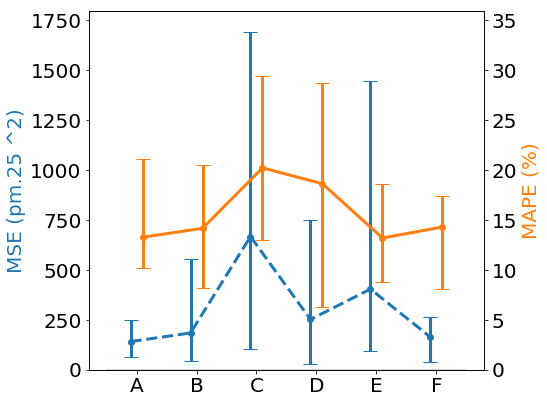

ours_w


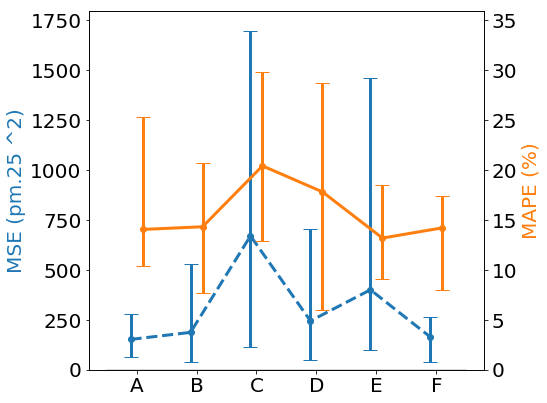

joint


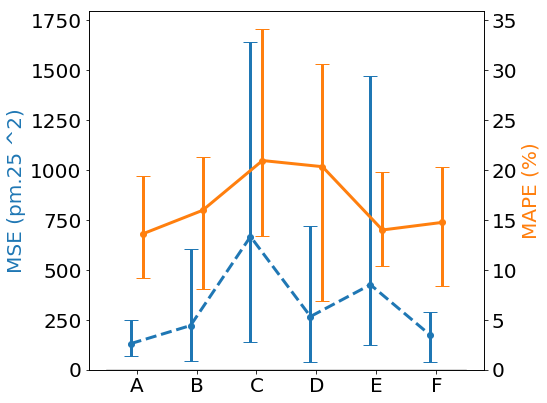

joint_w


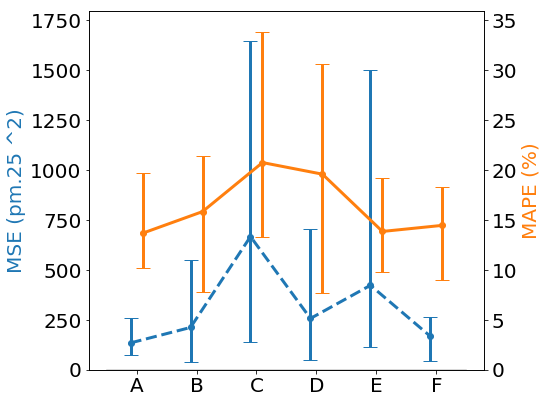

In [229]:
for mode in ['ours', 'ours_w', 'joint', 'joint_w']:
    print(mode)
    mse = [loc_avg_prop(
        mode, ii, 'MSE_TEST') for ii in range(nTargets)]
    mape = [loc_avg_prop(mode, ii, 'MAPE') for ii in range(nTargets)]

#     fig, axleft = plt.subplots(figsize=(14, 5))
    fig, axleft = plt.subplots(figsize=(8, 6))

    plt.rc('font', size=20)
    plt.rc('ps', useafm=True)
    plt.rc('pdf', use14corefonts=True)
    
    axleft.plot([-0.5, 5.5], [0,0], color='#CCCCCC')

    yscale = (-30, 150)
    components = zip(*mse)
    mus, mins, maxs = [np.array(ls) for ls in components]
    p0 = axleft.errorbar(
        np.arange(len(mus))-0.1, 
        mus, 
        yerr=[mus - mins, maxs - mus], capsize=7, linewidth=3, fmt='--o')
    axleft.set_ylim(0, 1800)

    axright = axleft.twinx()
    components = zip(*mape)
    scale = 1
    mus, mins, maxs = [np.array(ls) *scale for ls in components]
    p1 = axright.errorbar(
        np.arange(len(mus)) + 0.1, 
        mus, 
        yerr=[mus - mins, maxs - mus], capsize=7, linewidth=3, fmt='-o', color='C1')
    axright.set_ylim(0, 36)

    axright.set_ylabel('MAPE (%)', color='C1')
    axleft.set_ylabel('MSE (pm.25 ^2)', color='C0')
    # plt.xticks(np.arange(6), [nm[0] for nm in SEGMENTS[3]['locations']])
    plt.xticks(np.arange(6), ['ABCDEF'[ii] for ii in range(6)])
    # plt.yticks(np.arange(0, 100, 10), np.arange(0, 100, 10))
    fig.tight_layout()
    plt.savefig('nn_mse_mape-%s.eps' % mode, bbox_inches='tight')
    plt.show(); plt.close()

In [209]:
def table_loc(mode, printout=False, stat=0):
    mdstr = ' (%s)' % mode
    
    mse = [loc_avg_prop(mode, ii, 'MSE_TEST')[stat] for ii in range(nTargets)]
    mape = [loc_avg_prop(mode, ii, 'MAPE')[stat] for ii in range(nTargets)]
    
    mseline = '\t'.join(['MSE%s' % mdstr] \
                    + ['%.2f' % val for val in mse] + ['%.2f' % np.mean(mse)])
    mapeline = '\t'.join(['MAPE%s' % mdstr] \
                    + ['%.2f' % val for val in mape] + ['%.2f' % np.mean(mape)])
    
    if printout:
        print(mseline)
        print(mapeline)
        
    return [mseline, mapeline]

_ = table_loc('ours', printout=True)

MSE (ours)	141.29	184.55	667.56	252.30	404.44	163.87	302.33
MAPE (ours)	13.29	14.18	20.23	18.64	13.21	14.30	15.64


In [216]:
def loc_table(stat=0):
    header = '\t'.join(['metric'] + ['ABCDEF'[ii] for ii in range(nTargets)] + ['loc-avg'])
    lines = table_loc('ours', stat=stat) + table_loc('ours_w', stat=stat) \
        + table_loc('joint', stat=stat) + table_loc('joint_w', stat=stat)

    with open('table-loc.tsv', 'w') as fl:
        print(header)
        fl.write(header + '\n')


        for jj in range(len(PROPS)):
            for ii in range(len(modes)):
                    ind = ii * len(PROPS) + jj
                    print(lines[ind])
                    fl.write(lines[ind] + '\n')
loc_table()

metric	A	B	C	D	E	F	loc-avg
MSE (ours)	141.29	184.55	667.56	252.30	404.44	163.87	302.33
MSE (ours_w)	152.16	187.52	670.85	244.87	400.88	164.03	303.38
MSE (joint)	130.89	221.70	667.48	266.96	426.43	173.14	314.44
MSE (joint_w)	134.75	212.12	667.46	257.19	423.30	167.59	310.40
MAPE (ours)	13.29	14.18	20.23	18.64	13.21	14.30	15.64
MAPE (ours_w)	14.06	14.33	20.43	17.83	13.20	14.22	15.68
MAPE (joint)	13.61	15.97	20.97	20.35	14.01	14.77	16.61
MAPE (joint_w)	13.68	15.85	20.76	19.60	13.86	14.47	16.37


In [215]:
loc_table(stat=2)

metric	A	B	C	D	E	F	loc-avg
MSE (ours)	249.85	552.91	1693.25	748.76	1444.84	266.09	825.95
MSE (ours_w)	278.53	529.39	1698.80	703.05	1459.68	265.71	822.53
MSE (joint)	247.07	603.43	1642.98	719.70	1473.77	289.45	829.40
MSE (joint_w)	257.33	547.71	1648.37	705.38	1503.14	262.33	820.71
MAPE (ours)	21.07	20.51	29.40	28.76	18.62	17.43	22.63
MAPE (ours_w)	25.35	20.77	29.84	28.71	18.55	17.38	23.43
MAPE (joint)	19.44	21.37	34.15	30.61	19.86	20.36	24.30
MAPE (joint_w)	19.71	21.44	33.85	30.66	19.19	18.30	23.86
